In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage      
import sklearn.feature_extraction.text as sk_text
import sklearn.cluster as sk_cluster
import sklearn.metrics as metrics
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
import datetime
startTime = datetime.datetime.now()
print(str(startTime))

2019-03-06 13:05:12.528044


In [2]:
tweets = pd.read_csv('clean_data.csv',dtype=str)
tweets['FrequencyOver20'] = tweets.FrequencyOver20.str.lower()
#print initial data
# tweets = tweets[tweets.UserID != 'KARTEL808']
tweets.head()


,Unnamed: 0,Name,ScreenName,UserID,FollowersCount,FriendsCount,Location,Description,CreatedAt,StatusID,Language,Place,RetweetCount,FavoriteCount,Text,HashMentions,FrequencyOver20,LocationSplit
0,6,David Walling,davidjwalling,106568768,975,2781,"Dallas, TX",Bloodletting secure algorithms close to the bone. #HealthIT security matters. Opinions my own. https://t.co/Dcpe6FteOq,Sat Oct 29 00:16:48 EEST 2016,792112907488079872,en,NaN,0,0,#infosec #Intel #ACM #IEEE Impacts Haswell microarch. Paper proposes mitigations that could prevent BTB-based side https://t.co/DW6vgRAPrv,#infosec #Intel #ACM #IEEE,#infosec,Dallas
1,13,Harry Binford,CaptainNormal,2447279666,895,1224,USA,"Proud Christian husband, frequent shooting range attendee, and former law enforcement. Lifetime member of the NRA. Pro-life, Jesus is Lord. America first.",Thu Oct 27 21:44:44 EEST 2016,791712249685676032,en,NaN,0,0,@WayneDupreeShow #climatechange is the democrats' attempt to play God,@WayneDupreeShow #climatechange,@waynedupreeshow #climatechange,USA
2,24,Deplorable Mina,minasmith64,2307021294,6808,6998,127.0.0.1,"Farm owner, horse lover, gun lover. Anti-Feminist. #RedneckTaliban:Warrant Officer (honorary) #GamerGate #AltRight #Trump2016",Wed Oct 26 16:02:10 EEST 2016,791263651617394688,en,"PlaceJSONImpl{name='Elgin', streetAddress='null', countryCode='US', id='7c4ae4537997a58f', country='United States', placeType='city', url='https://api.twitter.com/1.1/geo/id/7c4ae4537997a58f.json', fullName='Elgin, IL', boundingBoxType='Polygon', boundingBoxCoordinates=[[Ltwitter4j.GeoLocation;@274e98b7], geometryType='null', geometryCoordinates=null, containedWithIn=[]}",0,0,Too bad #MegynKelly remains obsessed w hammering every #Trump2016 surrogate on her show w salacious sex charges no https://t.co/SPWkgHpqcE,#MegynKelly #Trump2016,#megynkelly #trump2016,127.0.0.1
3,34,My Info,chrisf91,2424856262,129,822,"San Antonio, TX","im not supersticous, but... i am a little sticious...",Fri Oct 28 09:34:20 EEST 2016,791890827974840322,en,NaN,0,0,"@mlombardifoxtv its ok to admit bill bellichick cusses out his players! Hey @ochocinco this dude dont beleive u, hes all on pats nuts.",@mlombardifoxtv @ochocinco,@ochocinco,San Antonio
4,40,Maria Sanchez,ShieldGirl127,1708905816,1084,2400,"Phoenix, AZ",LUCHA UNDERGROUND/WWE/Teen Wolf/The Walking Dead/Total Divas/Total Bellas Fan.If Your Not Smiling Your Doing It Wrong. SMILEMORE,Mon Oct 31 04:48:16 EET 2016,792921100418060289,en,"PlaceJSONImpl{name='Phoenix', streetAddress='null', countryCode='US', id='5c62ffb0f0f3479d', country='United States', placeType='city', url='https://api.twitter.com/1.1/geo/id/5c62ffb0f0f3479d.json', fullName='Phoenix, AZ', boundingBoxType='Polygon', boundingBoxCoordinates=[[Ltwitter4j.GeoLocation;@12c35d2d], geometryType='null', geometryCoordinates=null, containedWithIn=[]}",0,0,Match hasn't started yet and these two women are killing it! #RawWomensChampion #HIAC,#RawWomensChampion #HIAC,#hiac,Phoenix


In [3]:
aggregateTweetsHashtags =tweets.groupby('UserID')['FrequencyOver20'].apply(lambda x: x.str.cat(sep=' '))
tweetsPrepareSKText = pd.DataFrame({'User_id': aggregateTweetsHashtags.index, 'All_hashtags': aggregateTweetsHashtags.values})
vectorizer = sk_text.TfidfVectorizer(max_features = 100,
                             #min_df=100, 
                             max_df=.8,
                             stop_words = 'english'
                             )


In [4]:
matrix = vectorizer.fit_transform(tweetsPrepareSKText.All_hashtags.values)
tdidf = matrix.toarray()
df_text = pd.DataFrame(matrix.todense(), index=aggregateTweetsHashtags.index, columns=vectorizer.get_feature_names())
df_text.head()

,abc,album,android,ap,armedradio,armedradio1,breitbartnews,business,cbsnews,clinton,...,trumppence16,trumptrain,washingtonpost,wdfx2eu7,wikileaks,win,worldseries,wsj,youngma,youtube
UserID,,,,,,,,,,,,,,,,,,,,,
100007440,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
100025240,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.187875,0.0,0.0,0.0,0.0,0.0
100132110,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.206227,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1001519173,0.0,0.0,0.0,0.0,0.0,0.0,0.285221,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.146219,0.233851,0.0,0.0,0.0,0.0,0.0
100174288,0.0,0.0,0.0,0.0,0.0,0.0,0.839738,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [5]:
ground_cols = ['UserID', 'GROUND_TRUTH_TEAM']
ground_truth = pd.read_table('clinton_trump_user_classes.txt', encoding ="ISO-8859-1", dtype=str, names= ground_cols)
#ground_truth.UserID = ground_truth.UserID.astype(int)
df_text = pd.merge(df_text, ground_truth, on = 'UserID')
#ground truth
true = df_text['GROUND_TRUTH_TEAM'].astype(int).values

In [20]:
#Cluster centers is acs_order_centroids
def printClusters(vectorizer,cluster_centers,num_cluster,num_to_print):
    des_order_centroids = cluster_centers[:,::-1]     #  get the indices that sort array in descending order
    terms = vectorizer.get_feature_names()

    for i in range(num_cluster):
        print ("Cluster:", i)
        for ind in des_order_centroids[i, :num_to_print]:
            print (terms[ind],vectorizer.vocabulary_[terms[ind]])
        print()  



In [21]:
def printMetrics(true,kmeans):
    print('confusion matrix\n',metrics.confusion_matrix(true, kmeans.labels_, labels=[0, 1]))
    print('Precision',metrics.precision_score(true, kmeans.labels_, average='weighted')) # weighted: the average precision of all clusters is returned
    print('Recall',metrics.recall_score(true, kmeans.labels_, average='weighted'))  # weighted: the average recall of all clusters is returned
    print('F1 Score',metrics.f1_score(true, kmeans.labels_, average= 'weighted'))     # weighted: the average f1 of all clusters is returned


**K-means Clustering**

In [8]:
%%time
kmeans = sk_cluster.KMeans(n_clusters=2, n_init=20, max_iter=200)  
km_labels = kmeans.fit_predict(tdidf)
error = kmeans.inertia_       #SSE; Sum of squared distances of samples to their closest cluster center.

CPU times: user 2.37 s, sys: 36.9 ms, total: 2.41 s
Wall time: 606 ms


In [22]:
print ("\nThe total error of the clustering is: ", error)


The total error of the clustering is:  [   0.         6872.88370136 6294.95455253 5901.63315973 5713.13763152
 5461.12075861 5324.95279675 5187.33792384 5046.58481654 4914.2258801
 4830.04957679 4789.05683686 4602.60592594 4551.15755857 4456.36373393
 4383.76339795 4251.28432202 4280.99798954 4179.30170893 4086.65100804]


In [23]:
printMetrics(true,kmeans)

confusion matrix
 [[1250  446]
 [1545  306]]
Precision 0.4277194916501769
Recall 0.17441990808205357
F1 Score 0.23280167599695128


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [11]:
printClusters(vectorizer, kmeans.cluster_centers_.argsort(),2,30)

Cluster: 0
youtube 99
realdonaldtrump 75
hillaryclinton 31
cnn 10
prisonplanet 71
realalexjones 74
breitbartnews 6
wikileaks 94
maga 46
wdfx2eu7 93
halloween 29
nodapl 62
foxnews 24
megynkelly 48
seanhannity 78
nytimes 66
trump 88
thedailybeast 86
dcexaminer 15
nypost 65
imwithher 34
wsj 97
fbi 22
washingtonpost 92
huffpostpol 32
worldseries 96
cubs 14
cnnpolitics 11
newtgingrich 59
draintheswamp 17

Cluster: 1
realdonaldtrump 75
hillaryclinton 31
foxnews 24
cnn 10
megynkelly 48
worldseries 96
trump 88
fbi 22
wikileaks 94
cubs 14
maga 46
washingtonpost 92
newtgingrich 59
msnbc 53
nytimes 66
imwithher 34
potus 70
kellyannepolls 41
seanhannity 78
halloween 29
joyannreid 40
jasoninthehouse 38
youtube 99
abc 0
kurteichenwald 42
draintheswamp 17
mitchellvii 50
gop 28
nodapl 62
cnnpolitics 11



**MAX-Agglomerative Clustering**

In [33]:
## parameter “linkage” to “complete” gives you MAX-based agglomerative hierarchical clustering

ag = sk_cluster.AgglomerativeClustering(linkage = 'complete', n_clusters = 2)   
ag_labels = ag.fit_predict(tdidf)

printMetrics(true,ag)

confusion matrix
 [[3351 1253]
 [3275 1042]]
Precision 0.48071444196506863
Recall 0.4924335836789598
F1 Score 0.4605192808384076


**SSE-Agglomerative Clustering**

In [31]:
## parameter “linkage” to “ward” gives you SSE-based agglomerative hierarchical clustering

ag = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 2)   
ag_labels = ag.fit_predict(tdidf)

printMetrics(true,ag)

confusion matrix
 [[4198  406]
 [4040  277]]
Precision 0.4592500230410856
Recall 0.5016253783208161
F1 Score 0.3910305002007533


## Task 1.3 (10 pts): Show the two respective word clouds of the two centers (centroids) by using hashtags/handles and their tfidf values. Hint: Use function fit_words() that comes with wordcloud

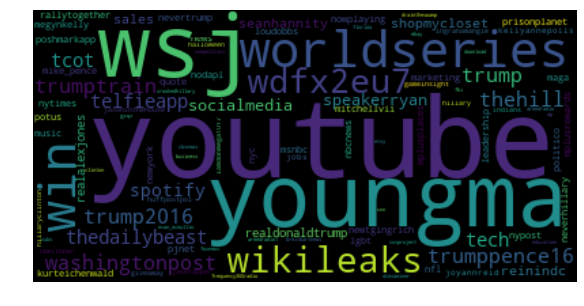

In [32]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).fit_words(vectorizer.vocabulary_)

# Display the generated image:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
ag = sk_cluster.AgglomerativeClustering(linkage = 'ward', n_clusters = 3)   

#complete: The maximum distances
#n_clusters: The number of clusters to find.

ag_labels = ag.fit_predict(tdidf)

print ('\nPrinting cluster assignment:')
ag_labels 


Printing cluster assignment:


array([0, 2, 0, ..., 0, 0, 2])

## 2.1: First, you apply the k-means algorithm. Create a plot of the SSE error of the k-means algorithm as a function of the number of clusters, for k up to 20, in order to determine the optimal number of clusters.


Text(0, 0.5, 'SSE')

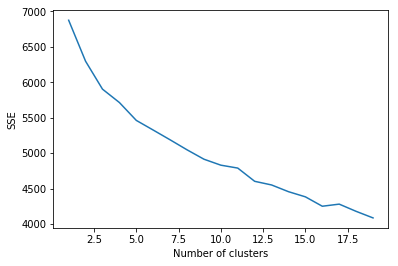

In [17]:
error = np.zeros(20)
for k in range(1,20):
    kmeans = sk_cluster.KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit_predict(tdidf)
    error[k] = kmeans.inertia_

plt.plot(range(1, 20), error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('SSE')

## 2.2: Run the k-means algorithm for the optimal number of clusters you identified in the last task. Print some hashtags/handles in each cluster. From the hashtags/handles in each cluster, try to deduce what is the topic it concerns. Include your conclusions in your report.

In [18]:
kmeans = sk_cluster.KMeans(n_clusters=20, n_init=10, max_iter=300)
kmeans.fit_predict(tdidf)
printClusters(vectorizer, kmeans.cluster_centers_.argsort(), 20,30)

Cluster: 0
nfl 61
nytimes 66
business 7
marketing 47
huffpostpol 32
giveaway 27
potus 70
wsj 97
news 58
thehill 87
tech 84
ebay 18
mplusplaces 51
socialmedia 80
abc 0
win 95
ap 3
etsy 20
leadership 43
breitbartnews 6
thedailybeast 86
nevertrump 57
hillaryclinton 31
indians 35
youtube 99
tcot 83
realdonaldtrump 75
mplusrewards 52
nbcnews 55
jobs 39

Cluster: 1
youtube 99
realdonaldtrump 75
hillaryclinton 31
realalexjones 74
breitbartnews 6
prisonplanet 71
cnn 10
wdfx2eu7 93
dcexaminer 15
nytimes 66
seanhannity 78
thedailybeast 86
wsj 97
foxnews 24
nypost 65
wikileaks 94
maga 46
jasoninthehouse 38
megynkelly 48
nodapl 62
fbi 22
cnnpolitics 11
huffpostpol 32
abc 0
nfl 61
halloween 29
potus 70
imwithher 34
msnbc 53
washingtonpost 92

Cluster: 2
nodapl 62
potus 70
hillaryclinton 31
realdonaldtrump 75
youtube 99
imwithher 34
wikileaks 94
trump 88
fbi 22
huffpostpol 32
nevertrump 57
cnn 10
draintheswamp 17
joyannreid 40
nytimes 66
halloween 29
clinton 9
thedailybeast 86
worldseries 96
msnbc 5